In [1]:
from trnasimtools.serialize import SerializeTwoCodonMultiTranscript
import os

In [2]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [3]:
#!mkdir ../yaml/august-1-2022
#!mkdir ../output/august-1-2022

In [10]:
# simulation parameters
time_limit = 500
time_step = 5
transcript_lens = [100, 100]
transcript_copy_numbers = [50, 50]
ribosome_copy_number = 100
total_trna = 100
ribosome_binding_rate = 100000.0
trna_charging_rates = [100000.0, 10.0]
transcript_names = ["proteinX", "proteinY"]
trna_props = (0.8, 0.2)
codon_comps_fixed = (0.5, 0.5)
codon_comps_var = [(x/100, (100-x)/100) for x in range(0, 101, 5)]

date = "august-1-2022"

In [8]:
for i in codon_comps_var:
    serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                               codon_comps=[codon_comps_fixed, i],
                                               trna_proportion=trna_props,
                                               transcript_names=transcript_names,
                                               time_limit=time_limit,
                                               time_step=time_step)
    serializer.serialize(f"../yaml/{date}")

In [11]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for trna_charging_rate in trna_charging_rates:
            for seed in range(1, 4):
                cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {transcript_copy_numbers[0]} {transcript_copy_numbers[1]} " + \
                  f"{ribosome_copy_number} {total_trna} {ribosome_binding_rate} {ribosome_binding_rate} {trna_charging_rate} {trna_charging_rate} ../output/{date}"
                stream.write(cmd)
                stream.write("\n")

In [27]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}-2.txt", "w") as stream:
    for config in configs:
        for seed in range(1, 4):
            cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {transcript_copy_numbers[0]} {transcript_copy_numbers[1]} " + \
              f"{ribosome_copy_number} {total_trna} {ribosome_binding_rate} {ribosome_binding_rate} 100.0 100.0 ../output/{date}"
            stream.write(cmd)
            stream.write("\n")

In [28]:
def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = pd.read_csv(f"{path}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    if tmp.empty:
        times = df_master["time"].to_list()
        dedup_times = []
        [dedup_times.append(x) for x in times if x not in dedup_times]
        next_best_time = take_closest(dedup_times, time)
        tmp = df_master.loc[df_master['time'] == next_best_time].groupby(["species"])["protein"].mean().reset_index()
    tmp["codon_comp"] = perc_good
    return tmp

In [45]:
df_master = None

trna_charging_rates_all = [100000.0, 100.0, 10.0]
for count, trna_charging_rate in enumerate(trna_charging_rates_all):
    df_tmp = None
    for codon_comp in codon_comps_var:
        codon_1, codon_2 = codon_comp
        path = f"../output/{date}/two_codon_multi_transcript_0.5_0.5_{codon_1}_{codon_2}_0.8_0.2" + \
               f"_{transcript_copy_numbers[0]}_{transcript_copy_numbers[1]}_{ribosome_copy_number}_{total_trna}" + \
               f"_{ribosome_binding_rate}_{ribosome_binding_rate}_{trna_charging_rate}_{trna_charging_rate}"
        tmp = get_average_protein(path, codon_1, 500, 3)
        tmp["tRNA_prop"] = trna_props[0]
        if df_tmp is not None:
            df_tmp = df_tmp.append(tmp, ignore_index=True)
        else:
            df_tmp = tmp
    df_tmp["tRNA_charging_rate"] = str(trna_charging_rate)
    if df_master is not None:
        df_master = df_master.append(df_tmp, ignore_index=True)
    else:
        df_master = df_tmp
df_master["species"] = df_master["species"].replace({"__ribosome": "free ribosome"})
df_master

,species,protein,codon_comp,tRNA_prop,tRNA_charging_rate
0,ATA_charged,19.5,0.0,0.8,100000.0
1,ATA_uncharged,0.5,0.0,0.8,100000.0
2,TTT_charged,79.5,0.0,0.8,100000.0
3,TTT_uncharged,0.5,0.0,0.8,100000.0
4,__proteinX_rbs,47.5,0.0,0.8,100000.0
...,...,...,...,...,...
562,__proteinX_rbs,43.5,1.0,0.8,10.0
563,__proteinY_rbs,48.5,1.0,0.8,10.0
564,free ribosome,8.0,1.0,0.8,10.0
565,proteinX,1695.5,1.0,0.8,10.0


In [50]:
#df_protein = df_master[(df_master.species == "proteinX") | (df_master.species == "proteinY") | (df_master.species == "__ribosome") | (df_master.species == "TTT_charged") | (df_master.species == "ATA_charged")]
df_protein = df_master[(df_master.species == "proteinX") | (df_master.species == "proteinY")]
df_protein = df_protein[(df_protein.tRNA_charging_rate == "10.0")]
df_protein

,species,protein,codon_comp,tRNA_prop,tRNA_charging_rate
385,proteinX,620.000000,0.00,0.8,10.0
386,proteinY,556.000000,0.00,0.8,10.0
394,proteinX,647.000000,0.05,0.8,10.0
395,proteinY,566.000000,0.05,0.8,10.0
403,proteinX,651.000000,0.10,0.8,10.0
404,proteinY,601.000000,0.10,0.8,10.0
412,proteinX,695.000000,0.15,0.8,10.0
413,proteinY,610.500000,0.15,0.8,10.0
421,proteinX,608.000000,0.20,0.8,10.0
422,proteinY,606.000000,0.20,0.8,10.0


Text(0, 0.5, 'Simulated protein')

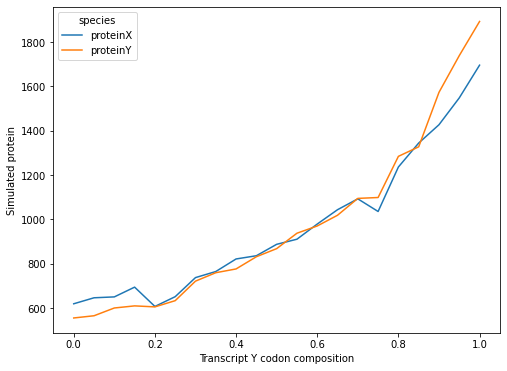

In [51]:
rcParams['figure.figsize'] = [8, 6]
sns.lineplot(data=df_protein, x="codon_comp", y="protein", hue="species")
plt.xlabel("Transcript Y codon composition")
plt.ylabel("Simulated protein")

Text(0, 0.5, 'Species counts')

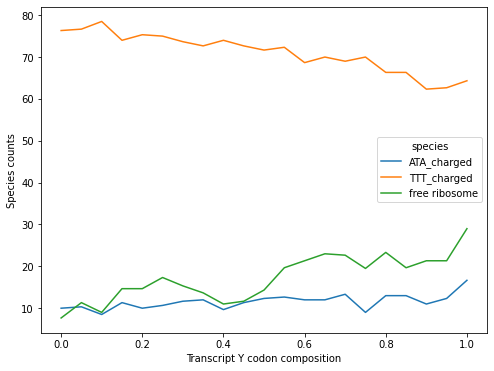

In [47]:
df_species = df_master[(df_master.species == "free ribosome") | (df_master.species == "TTT_charged") | (df_master.species == "ATA_charged")]
df_species = df_species[(df_species.tRNA_charging_rate == "100.0")]
rcParams['figure.figsize'] = [8, 6]
sns.lineplot(data=df_species, x="codon_comp", y="protein", hue="species")
plt.xlabel("Transcript Y codon composition")
plt.ylabel("Species counts")